In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/MyDrive/DL final project') # add shortcut to the DL final project to your google drive

Mounted at /content/drive


In [2]:
import os

import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision # for vgg16/19
from PIL import Image

from torchvision import transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

In [3]:
# df path, participant, image, arousal, valence 

df = {
    'path':[], 'participant':[], 'image_seq':[], 'image':[], 'arousal':[], 'valence':[] 
}
imgs = os.listdir('Images')
imgs_lower = [i.lower() for i in imgs]

for part in os.listdir('prep_data/epochs/'):
    for path in os.listdir('prep_data/epochs/'+part):
        df['path'] = df['path'] + [path]
        df['participant'] = df['participant'] + [int(part)]
        df['image_seq'] = df['image_seq'] + [int(path.split('_')[0])]
        
        if path.split('_')[1].lower()+'.jpg' not in imgs: # there are some troubles with imgs_lower letter cases for some images
            idx = imgs_lower.index(path.split('_')[1]+'.jpg')
            df['image'] = df['image'] + [imgs[idx]]
        else:
            df['image'] = df['image'] + [path.split('_')[1]+'.jpg']
            
        df['arousal'] = df['arousal'] + [int(path.split('_')[-2])]
        df['valence'] = df['valence'] + [int(path.split('_')[-1][:-4])]
        
df = pd.DataFrame(df)
df = df.sort_values(by=['participant', 'image_seq'])

In [4]:
df

,path,participant,image_seq,image,arousal,valence
0,0_dog 7_4_6.csv,0,0,dog 7.jpg,4,6
111,1_falcon 1_4_5.csv,0,1,falcon 1.jpg,4,5
122,2_koi fish 1_5_1.csv,0,2,koi fish 1.jpg,5,1
133,3_kazan 4_4_4.csv,0,3,kazan 4.jpg,4,4
144,4_embroidery 1_4_4.csv,0,4,embroidery 1.jpg,4,4
...,...,...,...,...,...,...
11684,165_weights 1_1_4.csv,159,165,weights 1.jpg,1,4
11685,166_tsarskoe selo 2_1_7.csv,159,166,tsarskoe selo 2.jpg,1,7
11686,167_wasp 2_1_4.csv,159,167,wasp 2.jpg,1,4
11687,168_sewing 1_1_5.csv,159,168,sewing 1.jpg,1,5


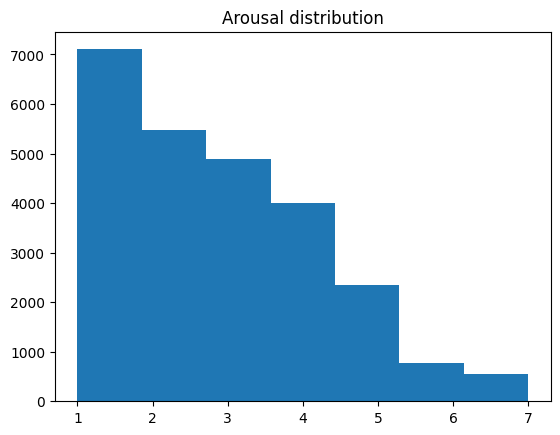

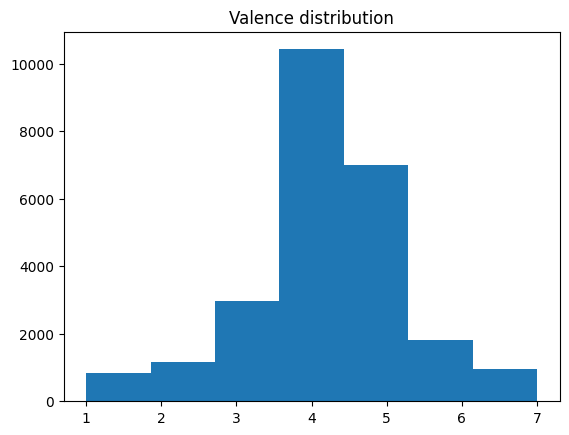

In [5]:
plt.hist(df.arousal, bins=7)
plt.title('Arousal distribution')
plt.show()

plt.hist(df.valence, bins=7)
plt.title('Valence distribution')
plt.show()

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5,std=0.5)
])

In [7]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df, main_folder='prep_data/epochs/', img_transform=transform):  # I use df to extract paths. We may filter df by images/participants/etc
        self.df = df
        self.arousal = np.array(df.arousal)
        self.valence = np.array(df.valence)
        
        self.paths = np.array(df.path)
        self.folder = np.array(df.participant)
        self.main_folder = main_folder
        
        self.img_names = np.array(df.image)
        self.img_transform = img_transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        
        data = pd.read_csv(self.main_folder+'/'+str(self.folder[idx])+'/'+self.paths[idx])
        y = torch.tensor([self.arousal[idx], self.valence[idx]]) 
        
        data.loc[[0, 300], ['FPOGV', 'LPMMV', 'RPMMV', 'GSRV', 'HRV']] = 1 # trick for interpolation to workaround cases when first/last values are not valid
        
        data.loc[data['FPOGV'] == 0, ['FPOGX', 'FPOGY']] = np.nan
        data.loc[data['LPMMV'] == 0, ['LPMM']] = np.nan
        data.loc[data['RPMMV'] == 0, ['RPMM']] = np.nan
        data.loc[data['GSRV'] == 0, ['GSR']] = np.nan
        data.loc[data['HRV'] == 0, ['HR']] = np.nan
        
        data[['FPOGX', 'FPOGY', 'FPOGID', 'LPMM', 'RPMM', 'GSR', 'HR']] = data[['FPOGX', 'FPOGY', 'FPOGID', 'LPMM', 'RPMM', 'GSR', 'HR']].interpolate(method='linear', axis=0)
        
        data['mean_PMM'] = (data.LPMMV + data.RPMMV)/2 
        
        data.GSR = data.GSR.rolling(window=60, min_periods=0, center=True).mean()
        data.mean_PMM = data.mean_PMM.rolling(window=10, min_periods=0, center=True).mean()
        
        ###
        # to create img from scan path - very straightforward but working function written in a noob way
        
        im_size = 180
        i1, i2 = 0, 300

        img_ = np.zeros((im_size, im_size), dtype=np.uint8)
        x0, y0 = data.FPOGX[i1], data.FPOGY[i1]
        for i in range(i1, i2):
            if ((data.FPOGID[i] != data.FPOGID[i+1])):

                x1, y1 = int(x0*im_size), int(y0*im_size)  
                x2, y2 = int(data.FPOGX[i]*im_size), int(data.FPOGY[i]*im_size)   

                cv2.line(img_, [x1, y1], [x2, y2], 255, 1)

                overlay = img_.copy()
                radius = int(((y2-y1)**2 + (x2-x1)**2)**0.5 / 5)
                cv2.circle(overlay, [x2, y2], radius, 255, -1)
                alpha = 0.5
                img_ = cv2.addWeighted(overlay, alpha, img_, 1 - alpha, 0)

                x0, y0 = data.FPOGX[i], data.FPOGY[i]

        x1, y1 = int(x0*im_size), int(y0*im_size)   
        x2, y2 = int(data.FPOGX[i2-1]*im_size), int(data.FPOGY[i2-1]*im_size)  

        cv2.line(img_, [x1, y1], [x2, y2], 255, 1)
        
        ###
        
        x_image = Image.open('Images/'+self.img_names[idx]).convert("RGB")
        x_image = self.img_transform(x_image)
        
        x_scanpath = (torch.tensor(img_, dtype=torch.float32)/255 - 0.5)/0.5
        
        
        # Normalize data by some reasonable values
        
        x_time = data[['FPOGX', 'FPOGY', 'mean_PMM', 'GSR', 'HR']]
        x_time = np.array(x_time)
        x_time = x_time.T
        x_time[[0, 1]] = (x_time[[0, 1]] - 0.5) / 0.5 # 'FPOGX', 'FPOGY' - X Y are from 0 to 1 with some outliers - lets normalise it by mean 0.5 and sd 0.5
        x_time[2] = (x_time[2] - 3)/0.4 # 'mean_PMM' - just rounded mean and sd of pupil size
        if round(x_time[3].std(), 3) == 0: # 'GSR' - GSR is veeeery noisy even in one recording - I use mean and sd for normalization of each epoch
            x_time[3] = 0
        else:
            x_time[3] = (x_time[3] - x_time[3].mean()) / x_time[3].std()
        
        x_time[4] = (x_time[4] - 80) / 15 # 'HR' - mean and sd of heart rate (BMP)
        x_time = torch.tensor(x_time, dtype=torch.float32)
        
        return x_image, x_scanpath, x_time, y

In [8]:
class CNN(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.batchnorm1 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(p)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(p)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(12544, 128) # change input size
        self.relu5 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(p)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.batchnorm1(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        x = self.dropout3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu5(x)
        x = self.batchnorm2(x)
        x = self.dropout4(x)
        return x

In [9]:
class CNN_LSTM(nn.Module):
    def __init__(self, p=0.1, n_features=5):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=64, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(p)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(input_size=148, hidden_size=64, batch_first=True)
        self.dropout2 = nn.Dropout(p)
        self.dense1 = nn.Linear(64, 20)
        self.relu3 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(20)

        # Wrap convolutional layers and dropout layer in a Sequential object
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=n_features, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool1d(kernel_size=2)
        )

    def forward(self, x):
        x = self.conv_layers(x)  # Apply convolutions to each time step
        x, _ = self.lstm(x)  # Apply LSTM
        x = self.dropout2(x[:, -1, :])  # Apply dropout to last time step
        x = self.dense1(x)
        x = self.relu3(x)
        x = self.batchnorm1(x)
        return x

In [10]:
base_model = models.vgg16()
for param in base_model.parameters():
    param.requires_grad = False

# Create new model on top.
class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = base_model.features
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        self.dropout1 = nn.Dropout(0.5)
        self.dense1 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(512, 64)
        self.batch_norm = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.base_model(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = self.dense1(x)
        x = self.dropout2(x)
        x = self.dense2(x)
        x = self.batch_norm(x)

        return x

In [11]:
class MultimoodalNN(nn.Module):
    def __init__(self, n_outputs=14, p=0.3):
        super().__init__()
        self.CNN = CNN()
        self.CNN_LSTM = CNN_LSTM()
        self.VGG16 = VGG16()
        self.concat = nn.Sequential(
            nn.Linear(128+20+64, 64),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, n_outputs)
        )
        self.soft = nn.Softmax(dim=1)
        
    def forward(self, x):
        x_image, x_scanpath, x_time = x
        
        x1 = self.CNN(x_scanpath[:, None])
        x2 = self.CNN_LSTM(x_time)
        x3 = self.VGG16(x_image)
        
        x = torch.cat((x1, x2, x3), dim=1)
        out = self.concat(x)
        out[:, :7] = self.soft(out[:, :7])
        out[:, 7:] = self.soft(out[:, 7:])
        
        return out

In [12]:
def balanced_split(df):
    k = max(len(df[df['arousal']==6]), len(df[df['arousal']==7]), len(df[df['valence']==1]), len(df[df['valence']==2]), len(df[df['valence']==6]), len(df[df['valence']==7]))

    df_neutral = df[df['arousal'].isin([1, 2, 3, 4, 5]) & df['valence'].isin([3, 4, 5])].sample(frac=1).iloc[0:k]
    df_not_neutral = df[df['arousal'].isin([5, 6, 7]) & df['valence'].isin([1, 2, 6, 7])]
    
    df = pd.concat([df_neutral, df_not_neutral], ignore_index=True)
    df = df.reset_index(drop=True)
    
    df = df.sample(frac=1)
    
    return df

In [13]:
batch_size = 8
test_list = np.random.choice(np.unique(df.image), 100, replace=False)

part_df = balanced_split(df[~df.image.isin(test_list)])

train_dataset = Dataset(part_df)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = Dataset(df[df.image.isin(test_list)])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

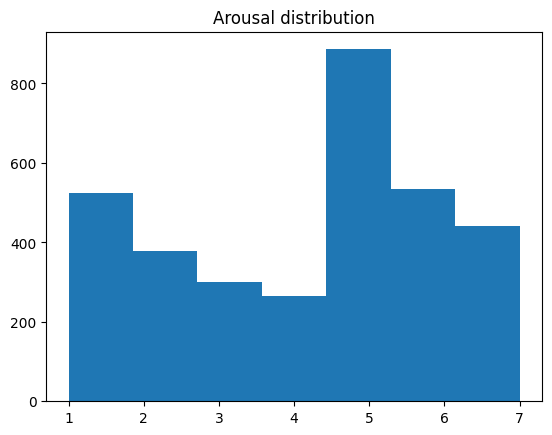

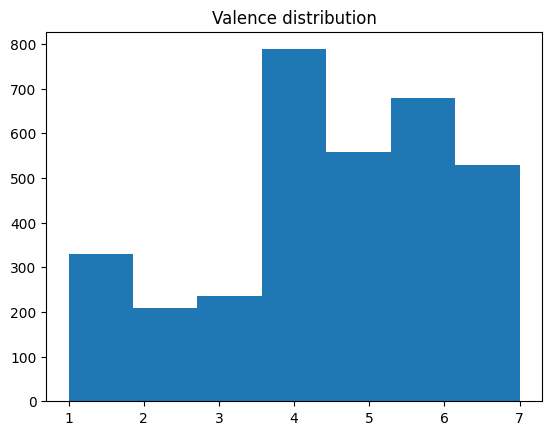

In [14]:
plt.hist(part_df.arousal, bins=7)
plt.title('Arousal distribution')
plt.show()

plt.hist(part_df.valence, bins=7)
plt.title('Valence distribution')
plt.show()

In [15]:
x_image, x_scanpath, x_time, y = next(iter(train_dataloader))

In [16]:
print(
    x_image.shape, # image shown
    x_scanpath.shape, # Scanpath (only fixation point)
    x_time.shape, # [X, Y, Pupil_size, Galvanic Skin Response, Heart Rate]
    y.shape # Arousal, Valence
)

torch.Size([8, 3, 256, 256]) torch.Size([8, 180, 180]) torch.Size([8, 5, 301]) torch.Size([8, 2])


In [17]:
import math
def scheduler(epoch):
    lr=0.01
    if epoch < 3:
        return lr
    elif lr <= 0.0001:
        return 0.0001
    else:
        return lr * math.exp(-0.1)

In [18]:
merged_model = MultimoodalNN()
merged_model.to(device)

optimizer = torch.optim.AdamW(merged_model.parameters(), lr=0.01)
callback = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=scheduler)

criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 60

L = []

# Training loop
for epoch in range(num_epochs):
    print(epoch)
    pbar = tqdm(train_dataloader)
    for x_image, x_scanpath, x_time, labels in pbar:
        x_image = x_image.to(device)
        x_scanpath = x_scanpath.to(device)
        x_time = x_time.to(device)
        labels = labels.to(device)
        labels = torch.nn.functional.one_hot(labels-1, num_classes=7)

        optimizer.zero_grad()
        outputs = merged_model([x_image, x_scanpath, x_time])
        loss = criterion(outputs, labels.reshape((labels.size(0), -1)).type(torch.float32))
        L.append(loss.item())
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Loss {loss:.4f}")
    
    # Update learning rate    
    callback.step()

# Evaluation loop
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_predicted = []
    for (x_image, x_scanpath, x_time, labels) in test_dataloader:
        x_image = x_image.to(device)
        x_scanpath = x_scanpath.to(device)
        x_time = x_time.to(device)
        labels = labels.to(device)
        labels = labels.type(torch.float32)
#         labels = torch.nn.functional.one_hot(labels-1, num_classes=7)
#         labels = labels.reshape((batch_size, -1)).type(torch.float32)
        
        outputs = merged_model([x_image, x_scanpath, x_time])
        predicted = torch.empty_like(labels)
        predicted[:, 0] = torch.max(outputs.data[:, :7], 1).indices
        predicted[:, 1] = torch.max(outputs.data[:, 7:], 1).indices
#         _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)*labels.size(1)
        correct += (predicted == (labels-1)).sum().item()
        
        y_true.append(labels)
        y_predicted.append(predicted)

    print(f'Test Accuracy of the model on the test images: {100 * correct / total :.4f} %')

0


Loss 5.2712:   3%|▎         | 11/416 [01:17<44:39,  6.62s/it]

In [ ]:
y_true = torch.cat(y_true).detach().cpu().numpy() - 1
y_pred = torch.cat(y_predicted).detach().cpu().numpy() - 1

In [ ]:
plt.plot(L)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
y_true

In [ ]:
mat_arousal = confusion_matrix(y_true[:, 0]-1, y_pred[:, 0], normalize='true')
mat_valence = confusion_matrix(y_true[:, 1]-1, y_pred[:, 1], normalize='true')

In [ ]:
(y_true[:, 0]-1 == y_pred[:, 0]).sum()/len(y_true)

In [ ]:
percent = np.round(mat_arousal / (mat_arousal.sum(axis=1)[None, :].T), 2)
cm_display = ConfusionMatrixDisplay(percent).plot()
plt.title('Arousal')
plt.show()

In [ ]:
percent = np.round(mat_valence / (mat_valence.sum(axis=1)[None, :].T), 2)
cm_display = ConfusionMatrixDisplay(percent).plot()
plt.title('Valence')
plt.show()

In [ ]:
(y_true[:, 1]-1 == y_pred[:, 1]).sum()/len(y_true)